# Data Overview

**What this notebook covers:**
- Load and examine the processed dataset
- Analyze missingness patterns and complete-case impact
- Review variable typing decisions
- Verify benign/malignant splits


In [15]:
# Config: File paths
# Robust path resolution: try to find project root
if (requireNamespace("here", quietly = TRUE)) {
  library(here)
  project_root <- here()
} else {
  # Fallback: assume notebook is in notebooks/ subdirectory
  current_dir <- getwd()
  if (basename(current_dir) == "notebooks") {
    project_root <- ".."
  } else {
    # Try to find project root by looking for config.yaml
    if (file.exists("config/config.yaml")) {
      project_root <- "."
    } else if (file.exists("../config/config.yaml")) {
      project_root <- ".."
    } else {
      # Last resort: use known absolute path
      project_root <- "/Users/brynnharrisshanks/Library/CloudStorage/GoogleDrive-hsbrynn@gmail.com/My Drive/st4health2025/final_projects/skin-cancer-feature-networks"
    }
  }
}

data_dir <- file.path(project_root, "data/processed")
results_dir <- file.path(project_root, "results/notebook_figures")

# Create results directory if it doesn't exist
dir.create(results_dir, showWarnings = FALSE, recursive = TRUE)

# Load libraries
library(readr)
library(dplyr)
library(ggplot2)
library(tidyr)

# Set working directory
setwd(project_root)


## 1. Load Processed Dataset


In [16]:
df <- read_csv(file.path(data_dir, "all_processed.csv"), show_col_types = FALSE)

cat("Dataset dimensions:", nrow(df), "rows ×", ncol(df), "columns\n\n")
cat("Column names:\n")
print(names(df))


Dataset dimensions: 1069 rows × 26 columns

Column names:
 [1] "patient_id"          "lesion_id"           "img_id"             
 [4] "diagnostic"          "smoke"               "drink"              
 [7] "background_father"   "background_mother"   "age"                
[10] "pesticide"           "gender"              "skin_cancer_history"
[13] "cancer_history"      "has_piped_water"     "has_sewage_system"  
[16] "fitspatrick"         "region"              "diameter_1"         
[19] "diameter_2"          "itch"                "grew"               
[22] "hurt"                "changed"             "bleed"              
[25] "elevation"           "biopsed"            


In [17]:
# Variable type counts
id_cols <- c("patient_id", "lesion_id", "img_id")
diagnosis_col <- "diagnostic"
analysis_vars <- setdiff(names(df), c(id_cols, diagnosis_col))

cat("Analysis variables:", length(analysis_vars), "\n\n")

# Count variable types
var_types <- sapply(df[, analysis_vars], function(x) {
  if (is.logical(x)) return("binary")
  if (is.factor(x)) return(ifelse(is.ordered(x), "ordinal", "categorical"))
  if (is.numeric(x)) {
    n_unique <- length(unique(x[!is.na(x)]))
    if (n_unique <= 2) return("binary")
    if (n_unique <= 10) return("categorical")
    return("continuous")
  }
  return("other")
})

type_counts <- table(var_types)
print(type_counts)


Analysis variables: 22 

var_types
     binary categorical  continuous       other 
         14           1           3           4 


In [18]:
# Diagnosis distribution
cat("Diagnosis distribution:\n\n")
diagnosis_table <- table(df[[diagnosis_col]])
print(diagnosis_table)

# Benign vs malignant
malignant_labels <- c("mel", "bcc", "scc")
df$is_malignant <- df[[diagnosis_col]] %in% malignant_labels
condition_table <- table(df$is_malignant)
names(condition_table) <- c("benign", "malignant")
cat("\nCondition distribution:\n")
print(condition_table)
cat("\nPercentages:\n")
print(round(100 * prop.table(condition_table), 1))


Diagnosis distribution:


ack bcc mel nev scc sek 
266 579  39  36 117  32 

Condition distribution:
   benign malignant 
      334       735 

Percentages:
   benign malignant 
     31.2      68.8 


## 2. Missingness + Complete-Case Impact


In [19]:
# Compute missingness per variable
missingness <- sapply(df[, analysis_vars], function(x) sum(is.na(x)))
missingness_pct <- 100 * missingness / nrow(df)
missingness_df <- data.frame(
  variable = names(missingness),
  n_missing = missingness,
  pct_missing = missingness_pct
) %>%
  arrange(desc(pct_missing))

cat("Top 15 variables by missingness:\n")
print(head(missingness_df, 15))


Top 15 variables by missingness:
                               variable n_missing pct_missing
smoke                             smoke         0           0
drink                             drink         0           0
background_father     background_father         0           0
background_mother     background_mother         0           0
age                                 age         0           0
pesticide                     pesticide         0           0
gender                           gender         0           0
skin_cancer_history skin_cancer_history         0           0
cancer_history           cancer_history         0           0
has_piped_water         has_piped_water         0           0
has_sewage_system     has_sewage_system         0           0
fitspatrick                 fitspatrick         0           0
region                           region         0           0
diameter_1                   diameter_1         0           0
diameter_2                   diameter

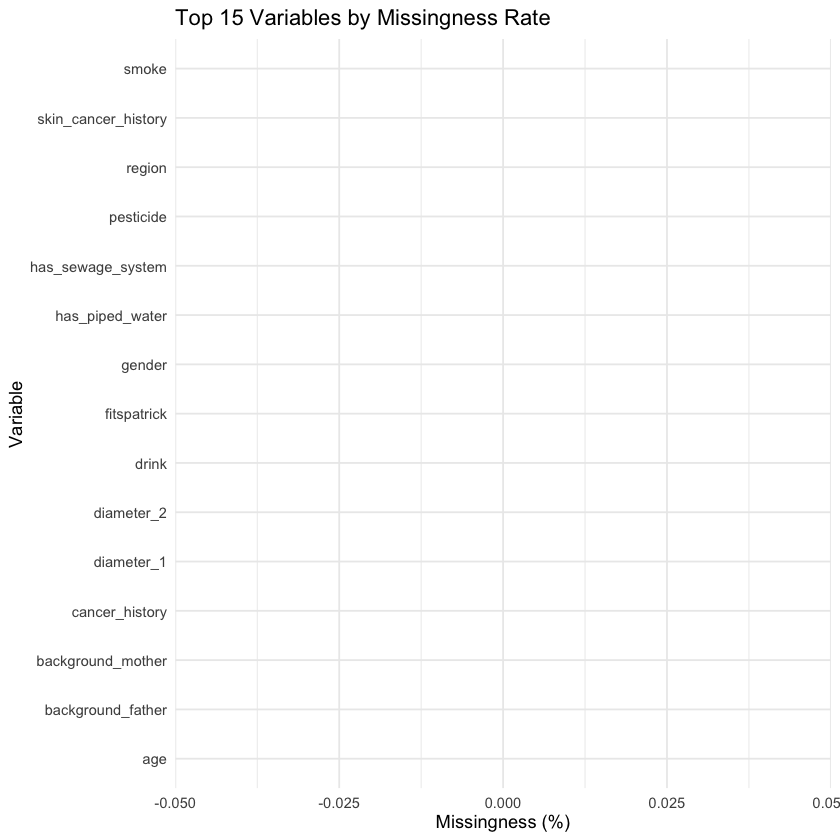

In [20]:
# Plot missingness (top 15)
p1 <- missingness_df %>%
  head(15) %>%
  ggplot(aes(x = reorder(variable, pct_missing), y = pct_missing)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(x = "Variable", y = "Missingness (%)", 
       title = "Top 15 Variables by Missingness Rate") +
  theme_minimal()

ggsave(file.path(results_dir, "missingness_top15.png"), p1, 
       width = 8, height = 6, dpi = 150)
print(p1)


In [21]:
# Load pre-complete-case data for comparison
df_pre <- read_csv(file.path(data_dir, "all_processed_pre_complete_case.csv"), 
                   show_col_types = FALSE)

n_pre <- nrow(df_pre)
n_post <- nrow(df)
n_dropped <- n_pre - n_post
pct_dropped <- 100 * n_dropped / n_pre

cat("Complete-case analysis impact:\n")
cat("  Pre-filter rows:", n_pre, "\n")
cat("  Post-filter rows:", n_post, "\n")
cat("  Dropped rows:", n_dropped, "(", round(pct_dropped, 1), "%)\n")


Complete-case analysis impact:
  Pre-filter rows: 2298 
  Post-filter rows: 1069 
  Dropped rows: 1229 ( 53.5 %)


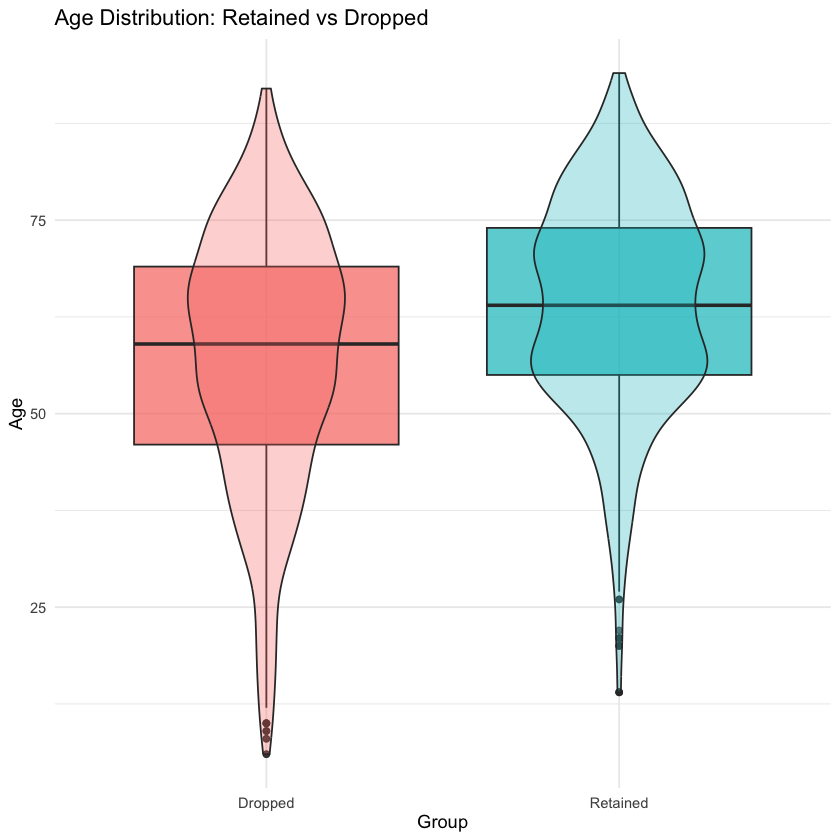

In [22]:
# Age distribution: retained vs dropped
df_pre$retained <- ifelse(df_pre$patient_id %in% df$patient_id, "Retained", "Dropped")

p2 <- ggplot(df_pre, aes(x = retained, y = age, fill = retained)) +
  geom_boxplot(alpha = 0.7) +
  geom_violin(alpha = 0.3, width = 0.5) +
  labs(x = "Group", y = "Age", title = "Age Distribution: Retained vs Dropped") +
  theme_minimal() +
  theme(legend.position = "none")

ggsave(file.path(results_dir, "retained_vs_dropped_age.png"), p2,
       width = 6, height = 5, dpi = 150)
print(p2)


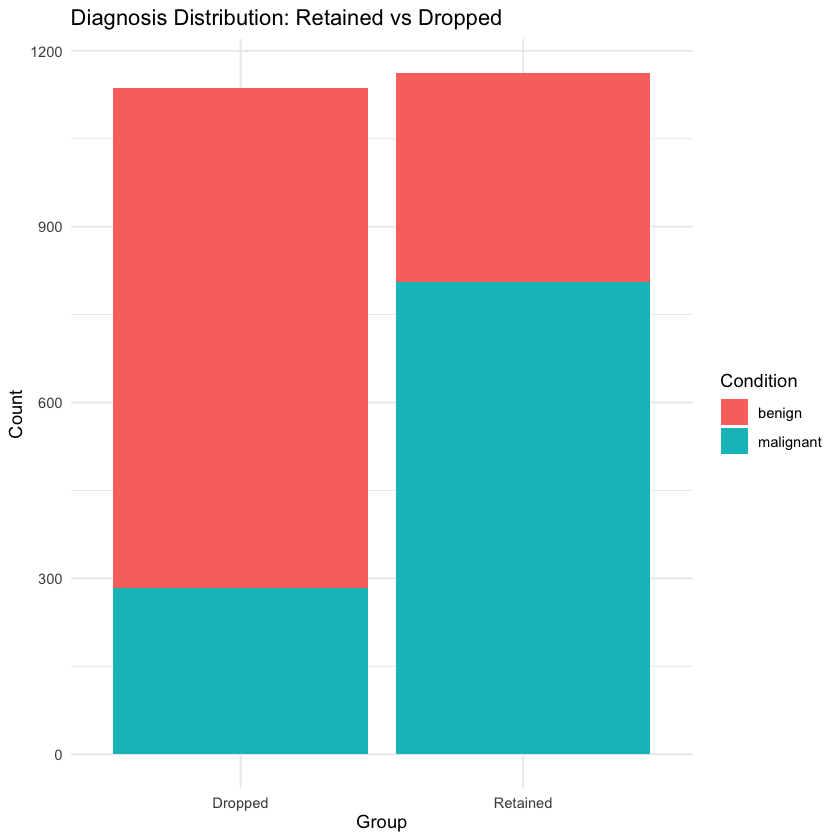

In [23]:
# Diagnosis distribution: retained vs dropped
df_pre$is_malignant_pre <- df_pre$diagnostic %in% malignant_labels
diagnosis_comparison <- df_pre %>%
  group_by(retained, is_malignant_pre) %>%
  summarise(count = n(), .groups = "drop") %>%
  mutate(condition = ifelse(is_malignant_pre, "malignant", "benign"))

p3 <- ggplot(diagnosis_comparison, aes(x = retained, y = count, fill = condition)) +
  geom_bar(stat = "identity", position = "stack") +
  labs(x = "Group", y = "Count", title = "Diagnosis Distribution: Retained vs Dropped",
       fill = "Condition") +
  theme_minimal()

ggsave(file.path(results_dir, "retained_vs_dropped_diagnosis.png"), p3,
       width = 6, height = 5, dpi = 150)
print(p3)


## Inclusion Flow Diagram


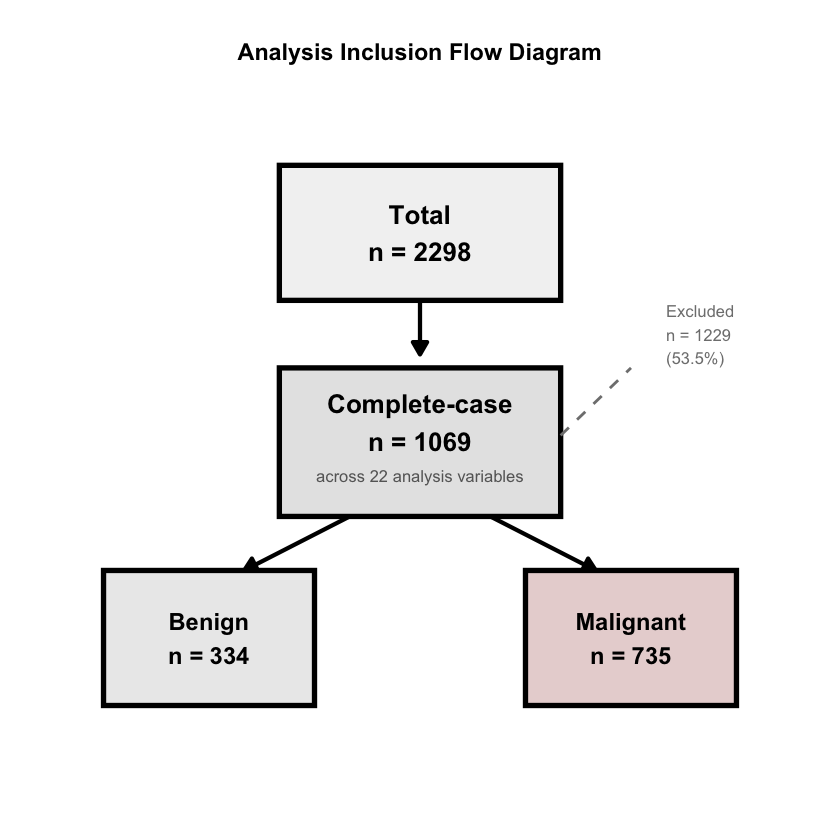

In [28]:
# Create inclusion flow diagram
library(grid)

# Get counts (already computed above)
n_total <- n_pre
n_complete <- n_post
n_dropped <- n_total - n_complete

# Get benign/malignant counts from split datasets
df_benign_check <- read_csv(file.path(data_dir, "benign.csv"), show_col_types = FALSE)
df_malignant_check <- read_csv(file.path(data_dir, "malignant.csv"), show_col_types = FALSE)
n_benign <- nrow(df_benign_check)
n_malignant <- nrow(df_malignant_check)

# Count analysis variables for context
n_analysis_vars <- length(analysis_vars)

# Create flow diagram with consistent formatting
p_flow <- ggplot() +
  # Total box - neutral light gray
  annotate("rect", xmin = 0.3, xmax = 0.7, ymin = 0.7, ymax = 0.9,
           fill = "gray95", color = "black", linewidth = 1.5) +
  annotate("text", x = 0.5, y = 0.8, 
           label = paste0("Total\nn = ", n_total),
           size = 5.5, fontface = "bold") +
  # Arrow: Total -> Complete-case
  annotate("segment", x = 0.5, xend = 0.5, y = 0.7, yend = 0.62,
           arrow = arrow(length = unit(0.3, "cm"), type = "closed"),
           linewidth = 1.2, color = "black") +
  # Complete-case box - neutral light blue-gray
  annotate("rect", xmin = 0.3, xmax = 0.7, ymin = 0.38, ymax = 0.6,
           fill = "gray90", color = "black", linewidth = 1.5) +
  annotate("text", x = 0.5, y = 0.52, 
           label = paste0("Complete-case\nn = ", n_complete),
           size = 5.5, fontface = "bold") +
  annotate("text", x = 0.5, y = 0.44,
           label = paste0("across ", n_analysis_vars, " analysis variables"),
           size = 3.5, color = "gray40", fontface = "plain") +
  # Arrow: Complete-case -> Benign
  annotate("segment", x = 0.4, xend = 0.25, y = 0.38, yend = 0.3,
           arrow = arrow(length = unit(0.3, "cm"), type = "closed"),
           linewidth = 1.2, color = "black") +
  # Arrow: Complete-case -> Malignant
  annotate("segment", x = 0.6, xend = 0.75, y = 0.38, yend = 0.3,
           arrow = arrow(length = unit(0.3, "cm"), type = "closed"),
           linewidth = 1.2, color = "black") +
  # Benign box - neutral light beige
  annotate("rect", xmin = 0.05, xmax = 0.35, ymin = 0.1, ymax = 0.3,
           fill = "gray92", color = "black", linewidth = 1.5) +
  annotate("text", x = 0.2, y = 0.2, 
           label = paste0("Benign\nn = ", n_benign),
           size = 5, fontface = "bold") +
  # Malignant box - softer, less saturated red
  annotate("rect", xmin = 0.65, xmax = 0.95, ymin = 0.1, ymax = 0.3,
           fill = "#E8D5D5", color = "black", linewidth = 1.5) +
  annotate("text", x = 0.8, y = 0.2, 
           label = paste0("Malignant\nn = ", n_malignant),
           size = 5, fontface = "bold") +
  # Excluded count annotation
  annotate("text", x = 0.85, y = 0.65, 
           label = paste0("Excluded\nn = ", n_dropped, "\n(", round(100 * n_dropped / n_total, 1), "%)"),
           size = 3.5, color = "gray50", hjust = 0) +
  annotate("segment", x = 0.7, xend = 0.8, y = 0.5, yend = 0.6,
           linetype = "dashed", color = "gray50", linewidth = 0.8) +
  labs(title = "Analysis Inclusion Flow Diagram") +
  theme_void() +
  theme(plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
        plot.margin = margin(20, 20, 20, 20)) +
  xlim(0, 1) + ylim(0, 1)

ggsave(file.path(results_dir, "inclusion_flow_diagram.png"), p_flow,
       width = 8, height = 10, dpi = 150)
print(p_flow)


## 3. Final Variable Typing Recap


In [25]:
# Create variable typing table
var_typing <- data.frame(
  variable = analysis_vars,
  type = var_types[analysis_vars],
  stringsAsFactors = FALSE
) %>%
  arrange(type, variable)

cat("Variable typing summary:\n\n")
print(var_typing, row.names = FALSE)

# Excluded variables
excluded_vars <- c(id_cols, diagnosis_col, "biopsed")
cat("\nExcluded variables:", paste(excluded_vars, collapse = ", "), "\n")
cat("  IDs:", paste(id_cols, collapse = ", "), "\n")
cat("  Diagnosis:", diagnosis_col, "\n")
cat("  Zero variance:", "biopsed", "\n")


Variable typing summary:

            variable        type
             biopsed      binary
               bleed      binary
      cancer_history      binary
             changed      binary
               drink      binary
           elevation      binary
                grew      binary
     has_piped_water      binary
   has_sewage_system      binary
                hurt      binary
                itch      binary
           pesticide      binary
 skin_cancer_history      binary
               smoke      binary
         fitspatrick categorical
                 age  continuous
          diameter_1  continuous
          diameter_2  continuous
   background_father       other
   background_mother       other
              gender       other
              region       other

Excluded variables: patient_id, lesion_id, img_id, diagnostic, biopsed 
  IDs: patient_id, lesion_id, img_id 
  Diagnosis: diagnostic 
  Zero variance: biopsed 


## 4. Splits Check


In [26]:
# Load split datasets
df_benign <- read_csv(file.path(data_dir, "benign.csv"), show_col_types = FALSE)
df_malignant <- read_csv(file.path(data_dir, "malignant.csv"), show_col_types = FALSE)

cat("Benign dataset:", nrow(df_benign), "rows ×", ncol(df_benign), "columns\n")
cat("Malignant dataset:", nrow(df_malignant), "rows ×", ncol(df_malignant), "columns\n")
cat("\nColumns match:", all(names(df_benign) == names(df_malignant)), "\n")


Benign dataset: 334 rows × 26 columns
Malignant dataset: 735 rows × 26 columns

Columns match: TRUE 


In [27]:
# Quick summaries
cat("Benign summary:\n")
cat("  Age: mean =", round(mean(df_benign$age, na.rm = TRUE), 1), 
    ", SD =", round(sd(df_benign$age, na.rm = TRUE), 1), "\n")
cat("  Smoke prevalence:", round(100 * mean(df_benign$smoke, na.rm = TRUE), 1), "%\n")
cat("  Drink prevalence:", round(100 * mean(df_benign$drink, na.rm = TRUE), 1), "%\n\n")

cat("Malignant summary:\n")
cat("  Age: mean =", round(mean(df_malignant$age, na.rm = TRUE), 1),
    ", SD =", round(sd(df_malignant$age, na.rm = TRUE), 1), "\n")
cat("  Smoke prevalence:", round(100 * mean(df_malignant$smoke, na.rm = TRUE), 1), "%\n")
cat("  Drink prevalence:", round(100 * mean(df_malignant$drink, na.rm = TRUE), 1), "%\n")


Benign summary:
  Age: mean = 62.5 , SD = 15 
  Smoke prevalence: 8.7 %
  Drink prevalence: 20.1 %

Malignant summary:
  Age: mean = 64.1 , SD = 13.8 
  Smoke prevalence: 15.5 %
  Drink prevalence: 25.3 %
